In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #
import sqlite3
import sklearn
import warnings

from collections import Counter
from sklearn.model_selection import train_test_split # split test and train
from sklearn.ensemble import RandomForestClassifier # Random Forests
from math import ceil # round up
from IPython.display import display


# Introduction

The following analysis uses data from the 2012-2013 National Health and Nutritional Survey (NHANES). The outcome variable for the analysis represents a subject's answer to the question, "Over the last 2 weeks, how often have you been bothered by the following problem: feeling down, depressed, or hopeless?" An outcome of 1 represents people who did not report feeling down or depressed at all, an outcome of 2 represents people who reported feeling down or depressed ocassionally, and a value of 3 represents people who reported feeling down or depressed frequently. The primary goal of this analysis is to build a model to predict a person's response using basic demographic characteristics and lifestyle factors such as race, unemployment status, and educational attainment. We are particularly interested in identifying individuals with responses of 2 or 3. 

# Examine Relationships Between Predictor Variables and Outcome

In [3]:
### Get data

# read data into pandas dataframe
data1 = pd.read_csv("https://raw.githubusercontent.com/kkeller88/Python-Practice/master/NHANES_data_sad.csv")

# read data into sql (incase i want to do more with this later)
cxn = sqlite3.connect('db1.sqlite')
data1.to_sql('table1',cxn,if_exists='replace',index='t')

# query sql database for population of interest
population1 = pd.read_sql("SELECT * FROM table1 WHERE (age>=25) AND (age<=65)",cxn)
total_samp_size = len(population1) # 3911

In [9]:
### Recode race/school/employment indicators as one variable

# duplicate new dataframe... **NOTE TO SELF: if you just do population2 = population1, changes to population 2 will change population1
population2 = population1.copy()

# simple function to create a new race variable, must be applied over rows of pd dataframe
def label_race(therow):
    if therow['hispanic'] == 1 :
        return 'Hispanic'
    if therow['black'] == 1 :
        return 'Black'
    if therow['asian'] == 1 :
        return 'Asian'
    if therow['other_race'] == 1 :
        return 'Other'
    else:
        return 'White'

# function to create a new school label for school variable, must be applied over rows of pd dataframe 
def label_school(therow):
    if therow['highschool_grad'] == 1 :
        return 'High School'
    if therow['college_grad'] == 1 :
        return 'College'
    else:
        return 'None'
    
# function to create a new employment label for employment variable, must be applied over rows of pd dataframe  
def label_employment(therow):
    if therow['unemployed_notlooking'] == 1 :
        return 'Unemployed Not Looking'
    if therow['unemployed_looking'] == 1 :
        return 'Unemployed Looking'
    else:
        return 'Employed'
    
# create new variables in new dataframe
population2['race'] = population2.apply(label_race,axis=1)
population2['school'] = population2.apply(label_school,axis=1)
population2['employment'] = population2.apply(label_employment,axis=1)

# drop variables i
population2 = population2.drop(['t','hispanic','black','asian','other_race','black','highschool_grad','college_grad','unemployed_notlooking','unemployed_looking'],axis=1)

In [10]:
### Create functions to calculate and graph proportions of people at each response level at each explanatory variable level

# FUNCTION crosstab_prop : Calculate proportion of people in each explanatory category with each response level 
#     INPUT exp : pandas series with explanatory variable
#     INPUT resp : pandas series with response variable 
#     OUTPUT prop
def crosstab_prop(resp,exp):
    crosstab = pd.crosstab(resp,exp)
    num = exp.value_counts().sort_index().tolist()
    prop_df = crosstab.divide(num)
    return prop_df

# FUNCTION plot_prop : Plots proportions of people in each explanatory variable category with response at each response leve
#    INPUT prop_df : pandas df from cross-tabulation with explanatory levels on columns and response levels on rows
#    INPUT (optional) plotind : list of values to locate plot in subplot command
#    INPUT (optional) pltshow : 1 = plot at end, 0 = do not plot at end 
# Note: plot does not show by default (better for tiling plots) 
# Note: does not plot legend for now (better for tiling plots) 
def plot_prop(prop_df,plotind=[1,1,1],pltshow=0):
    # initial values
    num_exp = prop_df.shape[1] # number of levels for explanatory variable
    num_response = prop_df.shape[0] # number of levels for response variable
    ind = np.arange(num_exp)
    width = 0.1
    colorlist = ['r','b','g','c','m','y','0.25','0.5','0.75'] # NOTE: Only 9 color options

    ax = plt.subplot(plotind[0],plotind[1],plotind[2]) ###

    # plot bars
    for i in range(num_response):
        plt.bar(ind+i*width,prop_df.iloc[i,:].tolist(),width,color=colorlist[i])

    # x axis
    ax.set_xticks(ind + width)
    ax.set_xticklabels(prop_df.columns.values.tolist(),fontsize='xx-small')
    
    # y axis
    ax.set_ylim([0,1])
    ax.set_ylabel('Proportion with Response',fontsize='x-small')
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize='xx-small')
    
    # overall title
    ax.set_title('{0}'.format(prop_df.columns.name),fontsize='x-small')
    
    # do we show plot automatically
    if pltshow == 1:
        plt.show()
    

# Categorical Variables

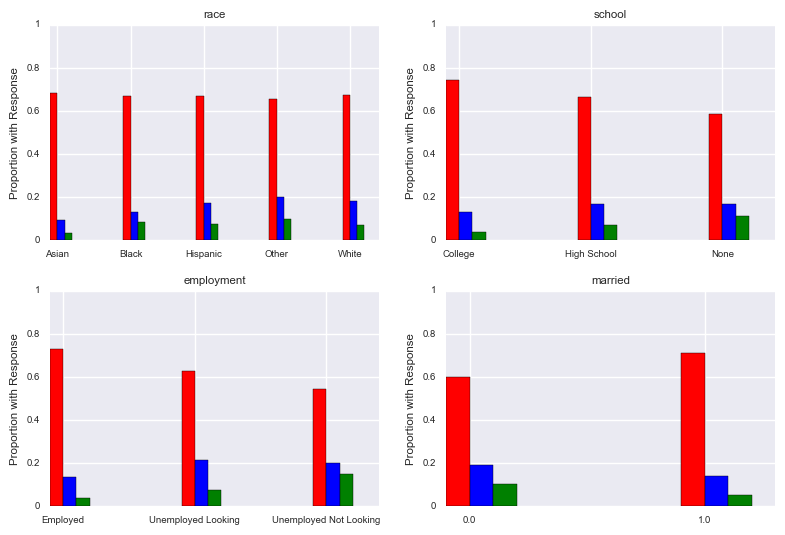

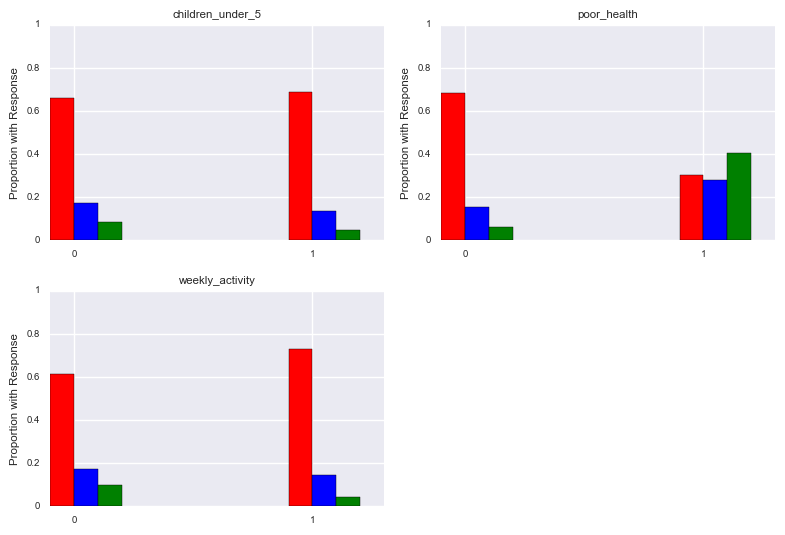

In [13]:
### cycle through each ctegorical variable and plot.... Note: Currently not legend, add when I have time

cat_list = ['race','school','employment','married','children_under_5','poor_health','weekly_activity']
cont_list = ['income_poverty','age','house_size']

# print out plots of categorical variables in sets of 2x2 tiled plots
for i in range(len(cat_list)):
    prop1 = crosstab_prop(population2['sad'],population2[cat_list[i]])
    
    # calculate plot index for subplot
    plotindex = (i+1)%4
    if plotindex == 0:
        plotindex = 4
      
    # for figure legend at bottom
    #if i == 4:
    #    fig = plt.figure()
    
    # plot
    plot_prop(prop1,[2,2,plotindex]) 
    
    # show plot every 4 plots to keep plots large enough in current area
    if ((i+1) % 4) == 0 :
        plt.tight_layout()
        plt.show()
    
# show remaining plots
plt.tight_layout()
plt.show()

Figures were created to display the proportion of people at each level for each explanatory variable that were at each level for the response variable. Note that some people did not have a recorded response variable, so the proportions at each explanatory level need not sum to 1. 

The largest difference in the distribution of responses was observed between the group of people with poor health and the group of people who were not in poor health. People who were in poor health seemed to be more unhappy than people who were not. Some other trends were observed. For example, it appeared that asians might be slightly less unhappy than other races and people who are are employed might happier than people that were unemployed, whether they were unemployed by choice or seeking employment. Note that we cannot say if any of these relationships are signifigant without further statistical tests. 

# Continuous Variables

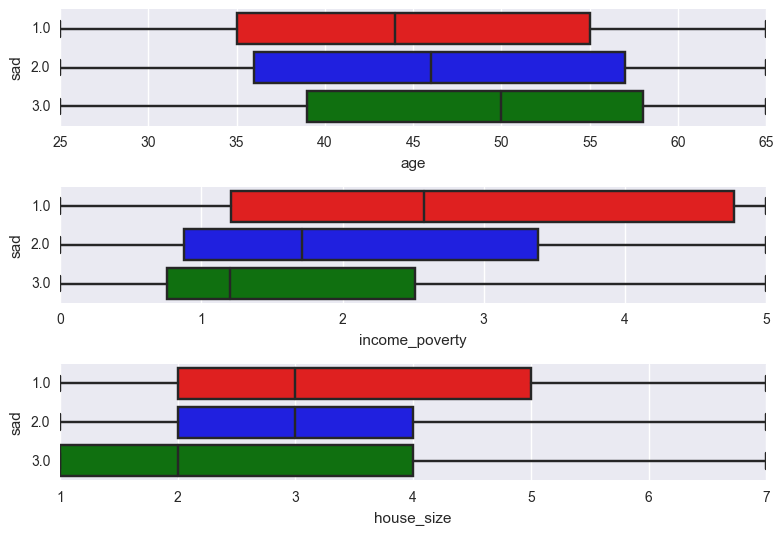

In [12]:
### plot continuous variable against levels

# define colorpalette
colors = sns.color_palette(['r','b','g'])

# create plot
ax = plt.subplot(3,1,1)
sns.boxplot(y="sad", x="age", data=population2,orient='h',palette=colors)

plt.subplot(3,1,2)
sns.boxplot(y="sad", x="income_poverty", data=population2,orient='h',palette=colors)

plt.subplot(3,1,3)
sns.boxplot(y="sad", x="house_size", data=population2,orient='h',palette=colors)

plt.tight_layout()
plt.show()

Boxplots were created at each response level for the continuous variables to examine the relationship between the continuous explanatory variables and the response variable. The most unhappy subjects appeared to have lower household sizes, have lower income to poverty ratios, and be slightly older. Again, note that we cannot say if any of these relationships are signifigant without further statistical tests. 

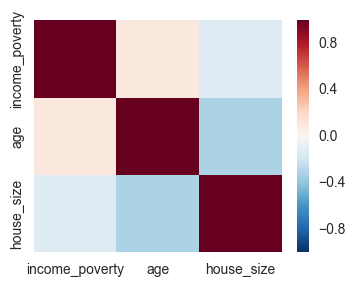

In [14]:
### Correlation among continuous variables

# calculate correlation matrix
corrmat = data1[cont_list].corr()

# simple plot

# Set up the matplotlib figure
plt.subplots(figsize=(4,3))

sns.heatmap(corrmat)

plt.show()

There do not appear to be any strong correlations between the continuous cariables in our data.

# Complete Case Analysis - Random Forests

First random forests will be generated using only observations with no missing data. When we analyze the data in this manner we assume that missing values are misssing completely at random and the complete cases do not differe systimatically from the incomplete cases. 3277 of the total 3911 cases will be included in this analysis. Data were split into 2621 training cases and 656 test cases. 

In [52]:
##### Split into test and train

# take only complete cases
data2 = population1.dropna()
lenComplete = len(data2) # 3277, 3911 before

# split into test and train
data2_train, data2_test = train_test_split(data2,test_size=0.2,random_state=3)

len_train2 = len(data2_train) # 2621
len_test2 = len(data2_test) # 656

# pull out x and y
y2_test = data2_test[[1]]
y2_train = data2_train[[1]]

x2_test = data2_test.iloc[:,2:]
x2_train = data2_train.iloc[:,2:]

# make numpy arrays for random forest
x2_train2 = x2_train.as_matrix()
y2_train2 = y2_train.as_matrix()
x2_test2 = x2_test.as_matrix()
y2_test2 = y2_test.as_matrix()


In [53]:
### Random Forest classifier on raw data with default parameters

# approximately half of predictors examined at each split
mtry1 = round(len(population1.columns)/2)

# fit random forests and make prediction
rf1 = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_features=mtry1,random_state=44,oob_score=True)
rfit1 = rf1.fit(X=x2_train2,y=y2_train2.ravel())

# get out of bag error 
oob_error1 = 1 - rfit1.oob_score_ 

print(oob_error1)

0.270888973674


A forest was built using entropy criteria with 1000 estimators, a minimum terminal node size of 1, and about half of all predictors used at each split. The average out of bag error for this tree was 27.09%, so an average of 27.09% of the observations not used to build a tree were predicted incorrectly using that individual tree. 

In [165]:
### Random Forest Parameters tuned: number of predictors considered for each split (mtry) and minimum number of observations in terminal nodes (nodeSize)

# get number of variables 
# x2_train2.shape[1] # 16 columns

# specify range of mtry and node size
mtry_list = [4,8,10,12,14,16]
nodeSize_list = [2, 10, 50, 100, 200]  

# random forest object w prameters as above
rfObject = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_features=mtry1,random_state=44,oob_score=True)

# initiliae empty data frame and fill with 
rf_grid = []

for mtry in mtry_list:
    for nodeSize in nodeSize_list:
        
        # set parameters and fit tree
        rfObject.set_params(max_features=mtry,min_samples_split=nodeSize)
        rfObject.fit(X=x2_train2,y=y2_train2.ravel())
        
        # calculate OOB error and append new row
        oob_error = 1 - rfObject.oob_score_ 
        rf_grid.append({'Mtry': mtry, 'Min_Node': nodeSize, 'Error': oob_error})
    
# save as df    
rf_error = pd.DataFrame(rf_grid)


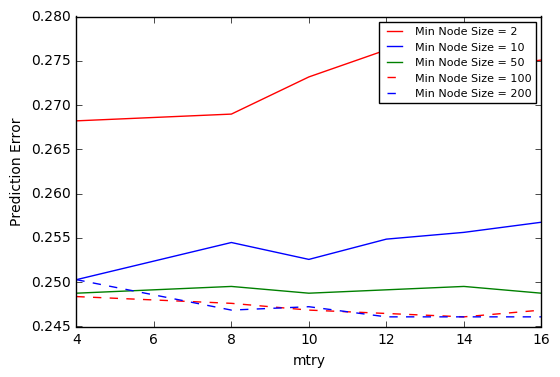

In [20]:
### Visualize error rates

# get oob error values corresponding to each node size
Node2 = rf_error.loc[rf_error['Min_Node'] == 2].iloc[:,0]
Node10 = rf_error.loc[rf_error['Min_Node'] == 10].iloc[:,0]
Node50 = rf_error.loc[rf_error['Min_Node'] == 50].iloc[:,0]
Node100 = rf_error.loc[rf_error['Min_Node'] == 100].iloc[:,0]
Node200 = rf_error.loc[rf_error['Min_Node'] == 200].iloc[:,0]

# create plot
fig, ax = plt.subplots()
plt.plot(mtry_list,Node2,'r', label='Min Node Size = 2')
plt.plot(mtry_list,Node10,'b', label='Min Node Size = 10')
plt.plot(mtry_list,Node50,'g', label='Min Node Size = 50')
plt.plot(mtry_list,Node100,'r--', label='Min Node Size = 100')
plt.plot(mtry_list,Node200,'b--', label='Min Node Size = 200')

ax.set_ylabel('Prediction Error')
ax.set_xlabel('mtry')
plt.legend(prop={'size':8})

plt.show()

# x axis is mtry
# series are min terminal node size


A grid search was performed to find the optimal values for 2 random forest parameters. Specifically, we examined the number of predictors examined at each split and the minimum internal node size for which a split was permitted. The values 4,8,10,12,14, and 16 were tested for number of predictors examined at each split. The values 2, 10, 50, 100, and 200 were used for the minimum internal node size for which a split was permitted. The OOB error was minimized when 12 and 200 were used for the number of predictors examined at each split and the minimum internal node size for which a split was permitted. The OOB prediction error was 24.61%.

In [24]:
### Random Forest Classifier with optimal parameters 
 
# save optimal 
min_error = rf_error.idxmin(axis=0)[0]
mtry_opt = int(rf_error.iloc[min_error][2])
nodeSize_opt = int(rf_error.iloc[min_error][1])

# fit random forest
rf2 = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_features=mtry_opt,min_samples_split=nodeSize_opt,random_state=44,oob_score=True)
rfit2 = rf2.fit(X=x2_train2,y=y2_train2.ravel())

# show values
print(['Predictors Considered = {0}'.format(mtry_opt),'Minimum Node Size = {0}'.format(nodeSize_opt),'OOB Error = {0}'.format(rf_error.iloc[min_error,0])])

['Predictors Considered = 12', 'Minimum Node Size = 200', 'OOB Error = 0.2460892789011827']


We now know the OOB prediction accuracy of our random forest, but we might also be interested in how well our model makes predictions for participants in specific response levels. Here a response of 1 represents a subject who did not report feeling down in the past 2 weeks, whereas responses of 2 and 3 represent subjects that did feel down. The majority of participants had a response of 1, so we could achieve relatively high prediction accuracy if we predicted all participants to have a response of 1. This model, however, would likely be of little use to us. Based on the context of our data, we would most likely be interested in identifying subjects who will likely respond with a 2 or a 3. We might want to flag these people as at risk for depression, or offer services to them that might help to improve their mood. In this case, we might be willing to chose a model with lower overall prediction accuracy if it does a better job identifying subjects who are unhappy and incorrectly predicting someone will have a response of 1 might be seen as worse than incorrectly predicting someone will have a response of 2 or 3. 

We will use 5-fold cross validation to select appropriate weights and compare the number of predicted outcomes at each level to the number of true outcomes at each level. 

In [227]:
### define functions to find optimal weights using cross vaidation

# FUNCTION cv_df_list : create a list of num_df pandas dataframes from a single dataframe
#     INPUT df : the dataframe to split
#     INPUT (optional) : the number of dataframes to split df into
#     OUTPUT df_list : list of num_df sub dataframes
def cv_df_list(df,num_df = 5):
    
    # randomly shuffle data
    np.random.seed(5)
    df2 = df.reindex(np.random.permutation(df.index))

    # get number to be in each set
    num_obs = df2.shape[0]
    num_each = round(num_obs/num_df) # let round up or down
    
    # create list of dataframes
    df_list = []
    for i in (range(num_df)):
        
        # get values to index dfs, df does not include stop location
        start = i*num_each
        stop = (i+1)*num_each 
    
        # split dataframe up at appropriate indexes
        if i == (num_df-1):
            df_list.append(df2.iloc[start:,:])
        else:
            df_list.append(df2.iloc[start:stop,:])
            
    return(df_list)
            

# FUNCTION cv_test_train : takes a list of n dataframes then creates test and train datasets for cross validation
#     INPUT df_list : list of n dataframes
#     OUTPUT [0] test_list : list of n test datasets
#     OUTPUT [1] train_list : list n train datasets
def cv_test_train(df_list):

    # initilize lists 
    testlist = []
    trainlist = []

    # calcualte test and train
    for i in range(len(cv_list)):

        # test 
        the_test = cv_list[i]

        # get train ... NOTE: better way to do this?
        if i == min(range(len(cv_list))):
            the_train = pd.concat(cv_list[(i+1):])
        elif i == max(range(len(cv_list))):
            the_train = pd.concat(cv_list[:i]) # concat does not include upper val
        else:
            the_train = pd.concat(cv_list[:i]+cv_list[(i+1):]) 

        # print(the_test.shape[0]+the_train.shape[0]) # test

        # add test and train datasets 
        testlist.append(the_test)
        trainlist.append(the_train)
        
    return([testlist,trainlist])
   
    
# FUNCTION rf_confusion : take in an rf object, test dataset, and train dataset and returns cross-tabulation of predicted vs true responses
#      INPUT rf_obf : random forest object
#      INPUT test_data : test dataframe
#      INPUT train_data : train dataframe
#      OUTPUT [0] count_pred : tabulation of predicted counts 
#      OUTPUT [1] count_true : tabulation of true counts 
#      OUTPUT [2] crosstab_1 : crosstabulation of predicted and true
#      OUTPUT [3] oob_score : OOB score
# NOTE: dataframes must be as here, with index at location 0, response at location 1, and explanatory variables 2 - end 
def rf_crosstab(rf_obj,test_data,train_data):

    # get test and train x and y values to use in rf
    test_y = test_data.iloc[:,1]
    test_x = test_data.iloc[:,2:]
    train_y = train_data.iloc[:,1]
    train_x = train_data.iloc[:,2:]

    # fit random forest using train data and predict on test data
    rfit = rf_obj.fit(X=train_x,y=train_y)
    rfit_predict = rfit.predict(test_x)

    #  crostabulation of predicted and true values 
    pred_v_true = pd.DataFrame({'pred':rfit_predict, 'true':test_y})
    cross_tab1 = pd.crosstab(pred_v_true['true'],pred_v_true['pred'])

    # overall counts of predicted and true values
    count_pred = Counter(rfit_predict)
    count_true = Counter(test_y)
    oob_score = rfit.oob_score_
    
    return([count_pred,count_true,cross_tab1,oob_score])

        

In [228]:
### Get counts of response levels and crosstabulation values in order

# get test and train datasets
cv_list = cv_df_list(data2_train) 
test_list,train_list = cv_test_train(cv_list)

# get crosstabulation of predicted and observed outcomes 
pred_list = []
true_list = []
crosstab_list = [] 

for i in range(len(test_list)):
    
    pred_i, true_i, crosstab_i, oob_score_i = rf_crosstab(rf2, test_list[i], train_list[i])
    pred_list.append(pd.DataFrame.from_dict(pred_i, orient='index').transpose()) # df
    true_list.append(pd.DataFrame.from_dict(true_i, orient='index').transpose()) # df
    crosstab_list.append(crosstab_i)

# convert list to single pandas df and take average of counts across cv folds
pred_df = pd.concat(pred_list)
pred_df_nomiss = pred_df.fillna(0)
pred_counts_final = pred_df_nomiss.mean(0)

true_df = pd.concat(true_list)
true_df_nomiss = true_df.fillna(0)
true_counts_final = true_df_nomiss.mean(0)

# average of cross tabulation df across cv folds 
sum_crosstab_df = crosstab_list[0].add(crosstab_list[1], axis='columns', level=None, fill_value=0).add(crosstab_list[2], axis='columns', level=None, fill_value=0).add(crosstab_list[3], axis='columns', level=None, fill_value=0).add(crosstab_list[4], axis='columns', level=None, fill_value=0)
mean_crosstab_df = sum_crosstab_df.divide(len(crosstab_list))

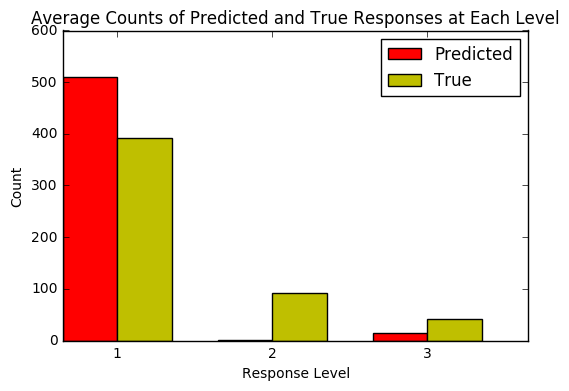

In [164]:
### Counts of true and predicted values

# Counts of predictions and true values
pred_vals = list(pred_counts_final) 
true_vals = list(true_counts_final) 

# make plot
ind = np.arange(3)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, pred_vals, width, color='r')
rects2 = ax.bar(ind + width, true_vals, width, color='y')

ax.set_ylabel('Count')
ax.set_xlabel('Response Level')
ax.set_title('Average Counts of Predicted and True Responses at Each Level')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1','2','3'))

ax.legend((rects1[0], rects2[0]), ('Predicted', 'True'))

plt.show()

While there are a good number of subjects with true responses of 2 or 3, but barely any responses of 2 and very few responses of 3 are seen in the predicted outcomes. This is problematic as we are particularly interested in predicting outcomes of 2 or 3. 

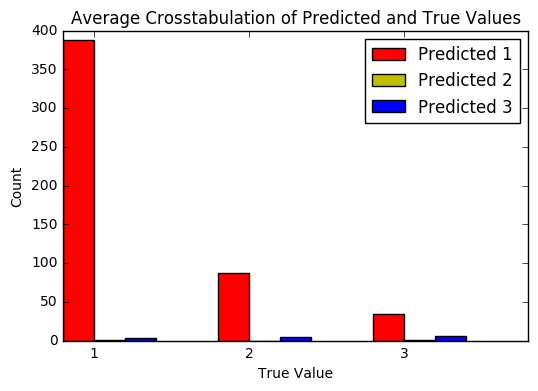

In [185]:
### visualize crosstabulation of predicted and true values

# extract values for bars.. true on x axis, pred in series
pred1 = mean_crosstab_df.iloc[:,0]
pred2 = mean_crosstab_df.iloc[:,1]
pred3 = mean_crosstab_df.iloc[:,2]

# make plot
ind = np.arange(3)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(ind, pred1, width, color='r')
rects2 = ax.bar(ind + width, pred2, width, color='y')
rects3 = ax.bar(ind + 2*width, pred3, width, color='b')

ax.set_ylabel('Count')
ax.set_xlabel('True Value')
ax.set_title('Average Crosstabulation of Predicted and True Values')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1','2','3'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Predicted 1', 'Predicted 2','Predicted 3'))

plt.show()


Reguardless of the true response for a subject, the majority of predicted responses are 1. There are even many subjects with true response values of 3 that have predicted responses of 1. 

In this forest, the minimum node size that permitted an additional split was 200. This value is relatively large value compared to the number of subjects in the training dataset, so the trees were not allowed to grow very deep. This may result in a loss of diversity in predicted responses. For example, say the first split in a tree resulted in an arm that had 190 subjects, 100 of which had a response of 1 and 90 of which had a response of 3. If we required 200 participants to make a split, we would likely just classify all these subjects as having a response of 1. If we loosened the requirement and allowed splits to be made for nodes with only 5 subjects, we might see a lot more subjects with a predicted response of 3. So if we lower the number of subjects was required in order for a split to be made, we might see more diversity in predicted responses.  

When the minimum node size that permits a split was lowered to 10, the overall prediction error was still relatively low. OOB prediction error was minimized when mtry was 4. When the minimum node size that permits a split was 2, an mtry size of 4 was also optimal.   

In [233]:
### COMPARE to smaller minimum node size (let tree grow out further, maybe we'll get some predicted 2s)

# FUNCTION cv_crosstab_avg : wrapper that gets average of predicted/true crosstabulation values across cv folds using rf_crosstab
#     INPUT rf_obj : random forest object
#     INPUT test_list : list of test dataframes
#     INPUT train_list : list of train dataframes
#     OUTPUT [0] mean_crosstab_df : mean of crosstabulation values across all folds
#     OUTPUT [1] mean_oob_score : mean oob score across folds
# NOTE: ONLY SET UP TO WORK FOR 5-FOLD CROSS VALIDATION
def cv_crosstab_avg(rf_obj,test_list,train_list):
 
    if len(train_list) != 5:
        warnings.warn("ONLY SET UP FOR USE WITH 5-FOLD CROSS VALIDATION")
        return
    
    # create list of crosstab values 
    crosstab_list = []  
    oob_score_list = []
    for i in range(len(test_list)):
        pred_i, true_i, crosstab_i, oob_score_i = rf_crosstab(rf_obj, test_list[i], train_list[i])
        crosstab_list.append(crosstab_i)
        oob_score_list.append(oob_score_i)

    # average across cv folds for crosstab
    sum_crosstab_df = crosstab_list[0].add(crosstab_list[1], axis='columns', level=None, fill_value=0).add(crosstab_list[2], axis='columns', level=None, fill_value=0).add(crosstab_list[3], axis='columns', level=None, fill_value=0).add(crosstab_list[4], axis='columns', level=None, fill_value=0)
    mean_crosstab_df = sum_crosstab_df.divide(len(crosstab_list))
    
    # average across folds for oob_score
    mean_oob_score = sum(oob_score_list)/len(oob_score_list)
    
    return(mean_crosstab_df,mean_oob_score)

# fit random forest: mtry = 4 and node size = 10 has low prediction error
rf3 = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_features=4,min_samples_split=10,random_state=44,oob_score=True)

# fit random forest: mtry = 4 and node size = 2
rf4 = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_features=4,min_samples_split=2,random_state=44,oob_score=True)

# crosstabulation
cross_tab2 = cv_crosstab_avg(rf3,test_list,train_list)[0]
cross_tab3 = cv_crosstab_avg(rf4,test_list,train_list)[0]

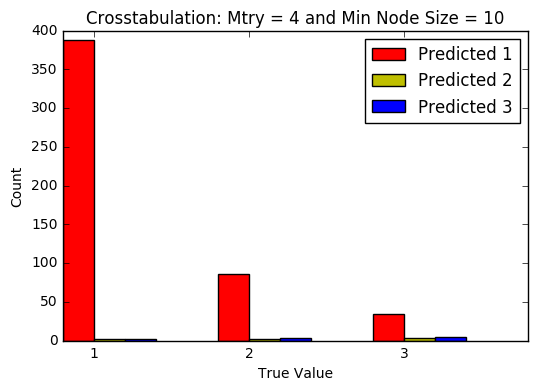

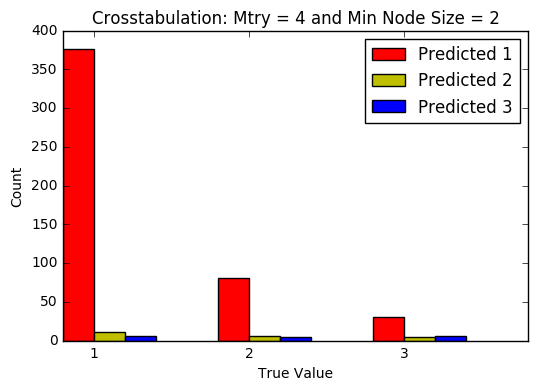

In [234]:
### Display results with different node size and mtry 

ind = np.arange(3)
width = 0.2

fig1, ax = plt.subplots()
rects1 = ax.bar(ind, cross_tab2.iloc[:,0], width, color='r')
rects2 = ax.bar(ind + width, cross_tab2.iloc[:,1], width, color='y')
rects3 = ax.bar(ind + 2*width, cross_tab2.iloc[:,2], width, color='b')

ax.set_ylabel('Count')
ax.set_xlabel('True Value')
ax.set_title('Crosstabulation: Mtry = 4 and Min Node Size = 10')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1','2','3'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Predicted 1', 'Predicted 2','Predicted 3'))

plt.show()

# make plot 2
ind = np.arange(3)
width = 0.2

fig1, ax = plt.subplots()
rects1 = ax.bar(ind, cross_tab3.iloc[:,0], width, color='r')
rects2 = ax.bar(ind + width, cross_tab3.iloc[:,1], width, color='y')
rects3 = ax.bar(ind + 2*width, cross_tab3.iloc[:,2], width, color='b')

ax.set_ylabel('Count')
ax.set_xlabel('True Value')
ax.set_title('Crosstabulation: Mtry = 4 and Min Node Size = 2')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1','2','3'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Predicted 1', 'Predicted 2','Predicted 3'))

plt.show()

# mtry = 4 and node size - 10 strikes good balance between overall predition accuracy and predicting 2 &

Lowering the minimum node size for which a split it permitted only slightly improved prediction of outcomes of 2 or 3, with a node size of 2 allowing for the most predicted 2s and 3s than a node size of 10. However, moving forward a minimum node size of 10 will be used to allow for a split because the OOB prediction error for a minimum node size of 2 was quite high compared to all other node sizes. Next weights were used to assign higher cost to misclassification of subjects with responses of 2 or 3. First, a random forest was fit using a weight of 1 for subjects that had a true outcome of 1 and a weight of 10 for subjects with a true outcome of 2 or 3. Relatively high weights were chosen for 2 and 3 to see how impactful weighting can be, but other weight values will also be tested. 


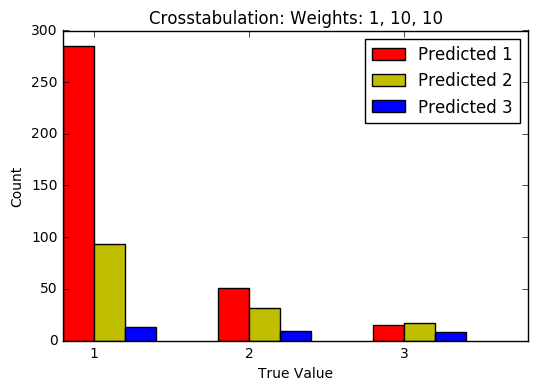

In [203]:
### ADJUST CLASS WEIGHTS

# adjust class weights, note that by default python uses weights inversly proportional to frequency
rf5 = RandomForestClassifier(class_weight={1.0:1, 2.0:10, 3.0:10},n_estimators=1000,criterion='entropy',max_features=4,min_samples_split=10,random_state=44,oob_score=True)

### 
cross_tab4 = cv_crosstab_avg(rf5,test_list,train_list)[0]

# plot 
ind = np.arange(3)
width = 0.2

fig1, ax = plt.subplots()
rects1 = ax.bar(ind, cross_tab4.iloc[:,0], width, color='r')
rects2 = ax.bar(ind + width, cross_tab4.iloc[:,1], width, color='y')
rects3 = ax.bar(ind + 2*width, cross_tab4.iloc[:,2], width, color='b')

ax.set_ylabel('Count')
ax.set_xlabel('True Value')
ax.set_title('Crosstabulation: Weights: 1, 10, 10')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1','2','3'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Predicted 1', 'Predicted 2','Predicted 3'))

plt.show()

Using these weights, many more predicted outcomes of 2 and 3 were observed. Predicted outcomes of 2 were still much more common than predicted outcomes of 3. 

To find optimal weights, a grid search was preformed where subjects with an outcome of 1 were always assigned a weight of 1 and the weights for subjects with true outcomes of 2 and 3 were chosen from the list 2, 5, 10, 15, and 20. The crosstabulation of predicted and true values was visualized, as was the overall OOB prediction error for each forest.


In [235]:
### Find weights that create good balance between overall prediction accuracy and predicting 2 and 3 

# initilize lists
weight2_list = [2,5,10,15,20]
weight3_list = [2,5,10,15,20]

rfObject2 = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_features=4,min_samples_split=10,random_state=44,oob_score=True)
rf_grid2 = []

for weight2 in weight2_list:
    for weight3 in weight3_list:
        
        # fit forest
        rfObject2.set_params(class_weight={1.0:1, 2.0:weight2, 3.0:weight3})
        
        # crosstab
        rf_cross_tab = cv_crosstab_avg(rfObject2,test_list,train_list)[0]
        
        # prediction error
        oob_error = 1 - cv_crosstab_avg(rfObject2,test_list,train_list)[1]

        # save values
        rf_grid2.append({'Weight2': weight2, 'Weight3': weight3, 'Error': oob_error, "Predicted1":rf_cross_tab.iloc[:,0],"Predicted2":rf_cross_tab.iloc[:,1],"Predicted3":rf_cross_tab.iloc[:,2]})
        

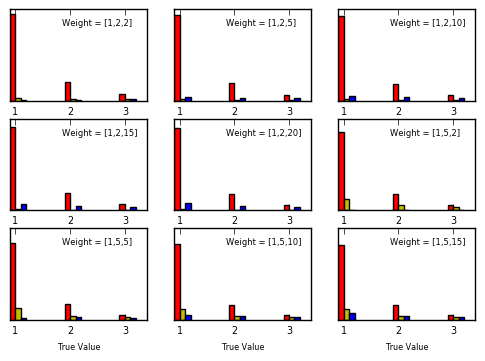

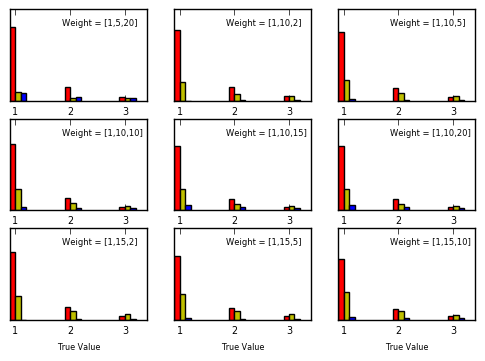

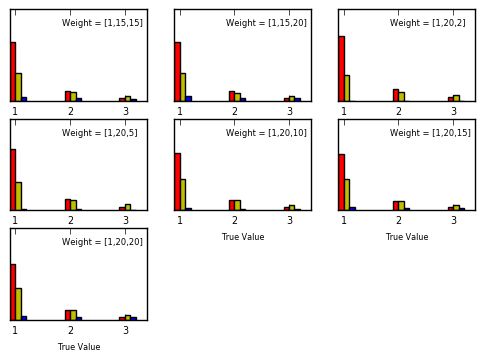

In [205]:
### plot crosstav]bulation of predicted and true.... NOTE: currently has no legend, add legend when i have time 

# get height of tallest bar
max_yaxis = []
for i in range(len(rf_grid2)):
    max_yaxis.append(rf_grid2[i]['Predicted1'].tolist()[0])
ymax = max(max_yaxis)

# get number of rows 
nplot = len(weight2_list)*len(weight3_list)
nrow = ceil(nplot/3) # make sure we round up

# other initial values for plots 
ind = np.arange(3)
width = 0.1

# make plots
for i in range(nplot):
    
    # calculate plot index for subplot
    plotindex = (i+1)%9
    if plotindex == 0:
        plotindex = 9
    
    # position
    ax = plt.subplot(3,3,plotindex)

    # plot bars
    plt.bar(ind, rf_grid2[i]['Predicted1'], width, color='r')
    plt.bar(ind + width, rf_grid2[i]['Predicted2'], width, color='y')
    plt.bar(ind + 2*width, rf_grid2[i]['Predicted3'], width, color='b')

    # ticks
    ax.set_yticklabels([])
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('1','2','3'),fontsize='x-small')
    ax.set_yticks([])
    
    # axis labels and axis values
    ax.set_xlabel('True Value',fontsize='xx-small')
    ax.set_ylim([0,ymax+20])
    
    # create text to label plot
    axtext = 'Weight = [1,{0},{1}]'.format(rf_grid2[i]['Weight2'], rf_grid2[i]['Weight3'])
    ax.text(0.95,ymax-50,axtext, fontsize=6)
        
    # print out every 9 plots, keeps plots at a good size    
    if ((i+1) % 9) == 0 :
        plt.show()
        
# show plots if there are plots left, note - works fine even if no unplotted plots remaining
plt.show()


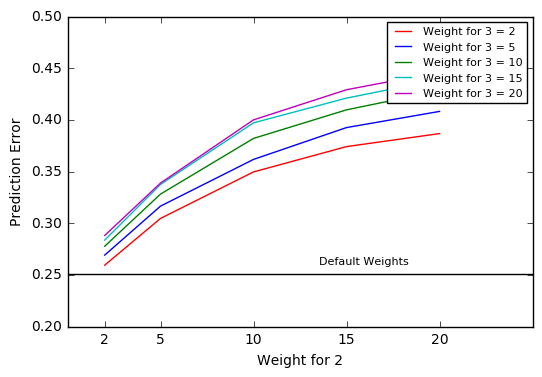

In [236]:
### plot OOB error

# make df with error values
rf_error_weights = []
for i in range(len(rf_grid2)):
        rf_error_weights.append({'Weight2': rf_grid2[i]['Weight2'], 'Weight3': rf_grid2[i]['Weight3'], 'Error': rf_grid2[i]['Error']})
rf_error_w = pd.DataFrame(rf_error_weights)

# extract error values for each different value of WEIGHT3... len(WEIGHT3) lists of length len(WEIGHT2)
error_df_list = [] # list of pandas dfs
for i in weight3_list: 
    dfi = rf_error_w.loc[rf_error_w['Weight3'] == i].iloc[:,0].tolist()
    error_df_list.append(dfi)

    
# make figure
fig, ax = plt.subplots()

# list of colors for lines !! Note: Only 9 color options - no more than 9 series
colorlist = ['r','b','g','c','m','y','0.25','0.5','0.75']

# add lines 
for i in range(len(error_df_list)):
    labeltext = 'Weight for 3 = {0}'.format(weight3_list[i])
    plt.plot(weight2_list,error_df_list[i],colorlist[i], label=labeltext)

# axis labels and ticks
ax.set_ylabel('Prediction Error')
ax.set_xlabel('Weight for 2')
ax.set_xticks(weight2_list)
ax.set_ylim([0.2,0.5])
ax.set_xlim([0,max(weight3_list)+5])

# add line and text
ax.axhline(1-rf3.oob_score_,color='k') # default weights
ax.text(13.5,0.26,'Default Weights',fontsize=8)

# legend
plt.legend(prop={'size':8})

plt.show()

Using weight of 5 or lower for the participants with true outcomes of 2 does not appear to be sufficient as there appear to be too few predicted outcomes of 2, and using a weight greater than 10 results in a large proportion of 1s beong predicted as 2s. When the weight for 2 is held constant at 10, not much improvement in the prediction of 3s is seen when the weight for participants with true responses of 3 is set to any value higher than 10 as compared to 10. Using a weight of 10 does appear to have advantage over a weight of 5. As such, the previous model with a weight of 10 for the subjects with true outcomes of 2 and 3 appears to be sufficient. The OOB prediction rate for this model is between 35% and 45%.

### Prediction Error on Test Data

In [322]:
# find prediction error on test data
predict_test = rf5.predict(x2_test).reshape((656,1))
true_test = y2_test.as_matrix()
error_test = 1-np.sum(predict_test == true_test)/predict_test.shape[0]

print('The OOB prediction error using training data is {0}'.format(1-cv_crosstab_avg(rf5,test_list,train_list)[1].round(4)))
print('The perdiction error using test data is {0}'.format(error_test.round(4)))

The OOB prediction error using training data is 0.382
The perdiction error using test data is 0.372
